In [2]:
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
G = nx.karate_club_graph()
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

In [4]:
colors = np.zeros(G.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i
n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]
y = torch.from_numpy(colors).long()

In [5]:
colors

array([2., 1., 1., 1., 2., 2., 2., 1., 0., 1., 2., 2., 1., 1., 0., 0., 2.,
       1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

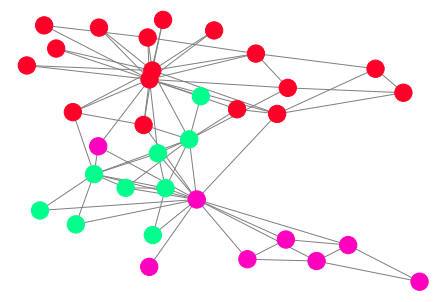

In [6]:
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_color=colors, cmap='gist_rainbow', edge_color='gray')

In [7]:
A = nx.to_numpy_array(G)
A_mod = A + np.eye(G.number_of_nodes())
D_mod = np.diag(A_mod.sum(axis=1))
D_mod_invroot = np.linalg.inv(scipy.linalg.sqrtm(D_mod))
A_hat = torch.from_numpy(D_mod_invroot @ A_mod @ D_mod_invroot).float()

X = torch.eye(G.number_of_nodes()).float()

In [8]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = torch.empty(n_inputs, n_outputs)
        nn.init.xavier_uniform_(W)
        self.W = nn.Parameter(W, requires_grad=True)
    
    def forward(self, A, X):
        return A @ X @ self.W
    
class GCNModel(nn.Module):
    def __init__(self, *n_neurons):
        super().__init__()
        self.layers = nn.Sequential(*[GCNLayer(n_inputs, n_outputs) for n_inputs, n_outputs in zip(n_neurons, n_neurons[1:])])
    
    def forward(self, A, X):
        for layer in self.layers[:-1]:
            X = layer(A, X)
            X = F.tanh(X)
        X = self.layers[-1](A, X)
        return X

    def get_embeddings(self, A, X):
        with torch.no_grad():
            for layer in self.layers[:-1]:
                X = layer(A, X)
                X = F.tanh(X)
        return X


In [9]:
gcn_model = GCNModel(G.number_of_nodes(), 16, 2, 3)
predictions = gcn_model(A_hat, X)
criterion = nn.CrossEntropyLoss()
criterion(predictions, y)

E:\anaconda3\envs\gcn\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(1.1242, grad_fn=<NllLossBackward>)

In [10]:
gcn_model

GCNModel(
  (layers): Sequential(
    (0): GCNLayer()
    (1): GCNLayer()
    (2): GCNLayer()
  )
)

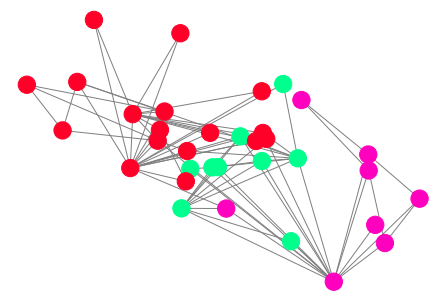

In [148]:
embeddings = gcn_model.get_embeddings(A_hat, X)
pos = {i: embeddings[i, :].tolist() for i in range(embeddings.shape[0])}
nx.draw(G, pos=pos, 
        with_labels=False, node_color=colors, 
        cmap='gist_rainbow', edge_color='gray')

In [149]:
train_nodes = torch.tensor([0, 1, 8])
test_nodes = torch.tensor([i for i in range(G.number_of_nodes()) if i not in train_nodes])

In [150]:
gcn_model = GCNModel(G.number_of_nodes(), 16, 2, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(gcn_model.parameters(), lr=0.001, momentum=0.9)

losses = []
for epoch in range(15000):
    y_pred = gcn_model.forward(A_hat, X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    if not epoch % 100:
        print(f'{epoch=} loss={loss.item()}')

epoch=0 loss=1.0813226699829102
epoch=100 loss=1.0540891885757446
epoch=200 loss=1.022783637046814
epoch=300 loss=0.9885023832321167
epoch=400 loss=0.9502134919166565
epoch=500 loss=0.9076370596885681
epoch=600 loss=0.861442506313324
epoch=700 loss=0.8132182955741882
epoch=800 loss=0.7650758624076843
epoch=900 loss=0.7190463542938232
epoch=1000 loss=0.6766113638877869
epoch=1100 loss=0.6385540962219238
epoch=1200 loss=0.6050610542297363
epoch=1300 loss=0.5759100914001465
epoch=1400 loss=0.5506482124328613
epoch=1500 loss=0.5287247896194458
epoch=1600 loss=0.5095791816711426
epoch=1700 loss=0.4926910996437073
epoch=1800 loss=0.47760409116744995
epoch=1900 loss=0.46393370628356934
epoch=2000 loss=0.45136427879333496
epoch=2100 loss=0.43964314460754395
epoch=2200 loss=0.4285728633403778
epoch=2300 loss=0.41800418496131897
epoch=2400 loss=0.4078291952610016
epoch=2500 loss=0.3979756832122803
epoch=2600 loss=0.388401597738266
epoch=2700 loss=0.3790893256664276
epoch=2800 loss=0.370040059089

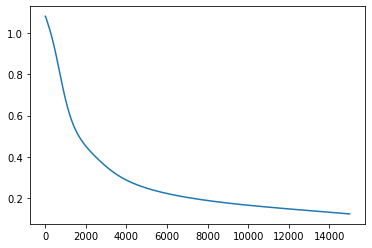

In [151]:
plt.plot(losses)

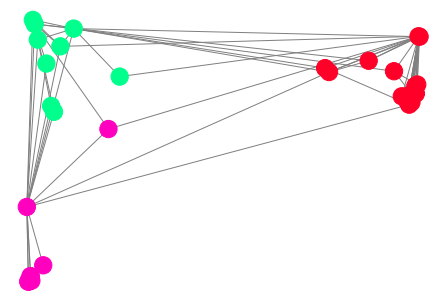

In [152]:
embeddings = gcn_model.get_embeddings(A_hat, X)
pos = {i: embeddings[i, :].tolist() for i in range(embeddings.shape[0])}
nx.draw(G, pos=pos, 
        with_labels=False, node_color=colors, 
        cmap='gist_rainbow', edge_color='gray')